In [1]:
import os, sys; sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import torch
import util.RAVDESS_dataset_util as Rd
import multimodal_vae
import matplotlib.pyplot as plt
import numpy as np
import torch_mvae_util as U
import pandas as pd
import seaborn as sn

from torchvision import transforms
from torch.utils.data import DataLoader
from train_mvae import build_model, train
from config_args import ConfigModelArgs, ConfigTrainArgs
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
cfg_model = ConfigModelArgs()
cfg_train = ConfigTrainArgs()

face_dataset = Rd.FaceEmotionDataset(
    root_dir=cfg_model.dataset_path,
    transform=transforms.Compose
    ([
        Rd.Rescale(int(cfg_model.img_size * 1.5)), 
        Rd.CenterCrop(int(cfg_model.img_size * 1.5)), 
        Rd.ToTensor()
    ]))

trainingset_len = len(face_dataset) // 100 * 80
testset_len = len(face_dataset) - trainingset_len
training_dataset, testing_dataset = torch.utils.data.random_split(
    face_dataset, 
    [trainingset_len, testset_len],
    generator=torch.Generator().manual_seed(66)
)

dataset_loader = DataLoader(training_dataset, batch_size=cfg_train.batch_size,
                        shuffle=False, num_workers=cfg_train.num_workers)

testset_loader = DataLoader(testing_dataset, batch_size=cfg_train.batch_size,
                        shuffle=False, num_workers=cfg_train.num_workers)

labels = list(Rd.emocat.values())
print('training set size: ',trainingset_len,'\ntest set size: ',testset_len)

training set size:  7840 
test set size:  2027


torch.Size([3, 64, 64])
calm


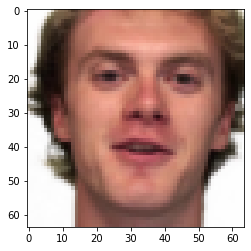

In [4]:
img = face_dataset[66]['image']
emo = face_dataset[66]['cat']
plt.imshow(np.array(img*255., dtype='uint8').transpose((1, 2, 0)))
print(img.shape)
print(Rd.emocat[1])

In [5]:
model_path = "../trained_models/RAVDESS_MVAE_moe.save"

loaded_data = torch.load(model_path)
model_args = loaded_data['model_args']
train_args = loaded_data['train_args']
losses = loaded_data['training_loss']

model: torch.nn.Module = build_model(**loaded_data['model_args']).double()
model.load_state_dict(loaded_data['model_params'])

<All keys matched successfully>

In [6]:
print(model_args)
print(train_args)

{'cat_dim': 8, 'latent_space_dim': 50, 'image_feature_size': 128, 'emotion_feature_size': 16, 'hidden_dim': 256, 'num_filters': 128, 'loss_weights': {'face': 1.0, 'emotion': 10000.0}, 'expert_type': 'moe', 'use_cuda': True}
{'learning_rate': 5e-06, 'optim_betas': [0.95, 0.98], 'num_epochs': 50, 'batch_size': 32}


## Loss

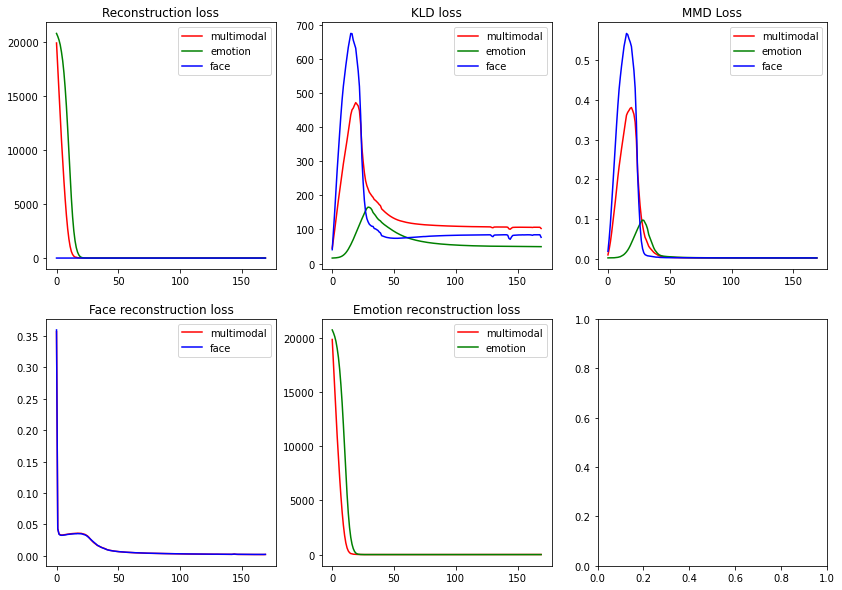

In [7]:
U.print_losses(losses)

## Images Reconstruction

### Image In, image Out

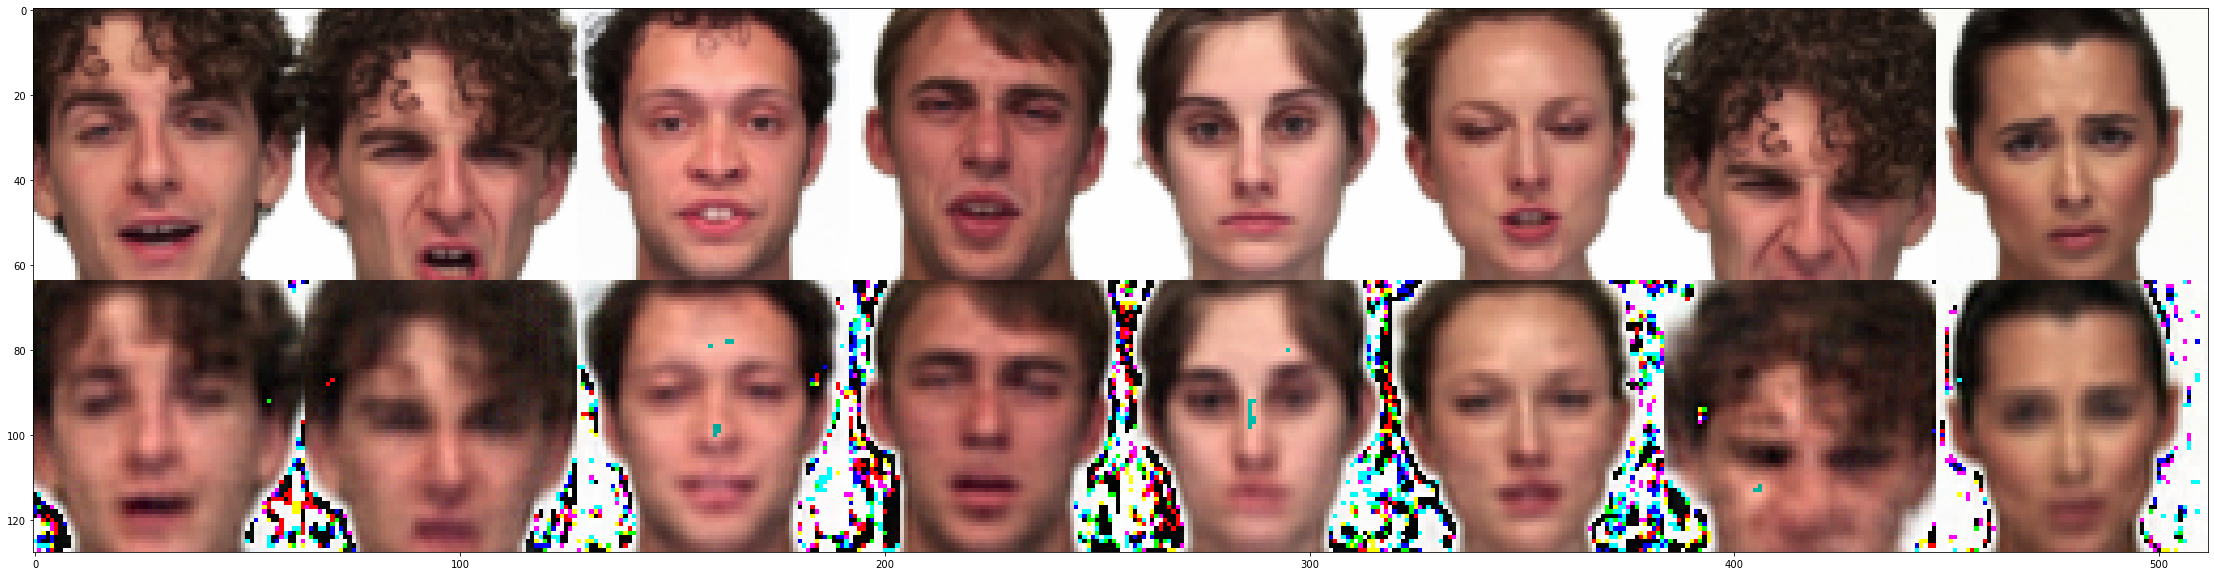

In [8]:
_ = U.images_to_images(model, testset_loader, num_images=8, model_eval=True)

## Image Classification

### Image In, emotion Out

100%|█████████████████████████████████████████████████████████████████████| 64/64 [00:27<00:00,  2.31it/s]


              precision    recall  f1-score   support

     neutral       0.67      0.87      0.76       129
        calm       0.81      0.75      0.78       269
       happy       0.75      0.72      0.74       271
         sad       0.73      0.74      0.74       257
       angry       0.76      0.70      0.73       294
     fearful       0.68      0.68      0.68       263
     disgust       0.79      0.69      0.73       280
   surprised       0.61      0.72      0.66       264

    accuracy                           0.73      2027
   macro avg       0.73      0.73      0.73      2027
weighted avg       0.73      0.73      0.73      2027



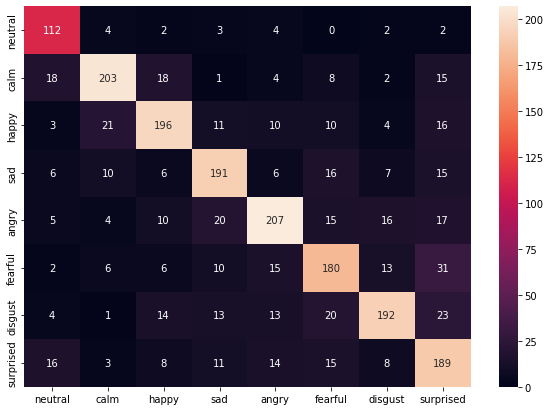

In [9]:
y_true, y_pred = U.classiffication_accuracy(model, testset_loader)
cr = classification_report(y_true, y_pred, target_names=labels)
cm = confusion_matrix(y_true, y_pred)
cm = pd.DataFrame(cm, index = [i for i in labels],columns = [i for i in labels])

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt="d")
print(cr)

## Image generation and classification

### Emotion In, Image Out

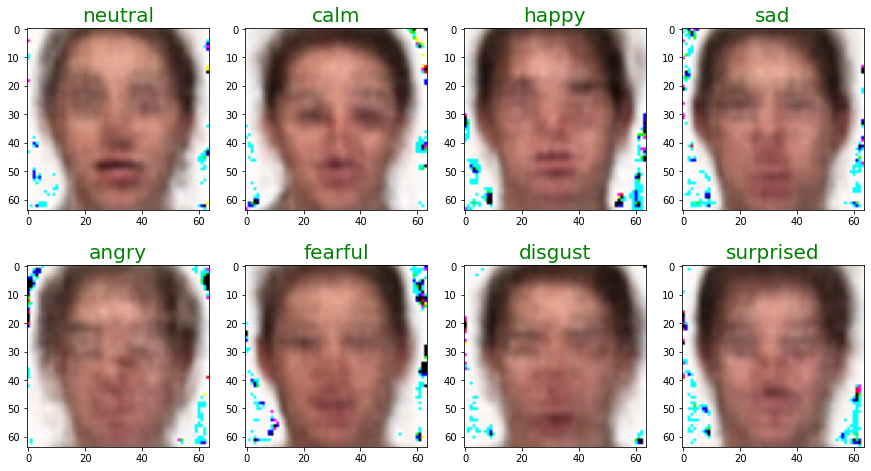

In [10]:
_ = U.emotions_to_images(model)

### Emotion In, Image Out -> Image In, Emotion Out

100%|█████████████████████████████████████████████████████████████████| 2048/2048 [01:59<00:00, 17.17it/s]


              precision    recall  f1-score   support

     neutral       0.58      0.90      0.71      4010
        calm       0.73      0.57      0.64      4014
       happy       0.60      0.44      0.51      4126
         sad       0.47      0.54      0.51      4123
       angry       0.76      0.44      0.56      4096
     fearful       0.67      0.22      0.33      4156
     disgust       0.42      0.72      0.53      4142
   surprised       0.48      0.57      0.52      4101

    accuracy                           0.55     32768
   macro avg       0.59      0.55      0.54     32768
weighted avg       0.59      0.55      0.54     32768



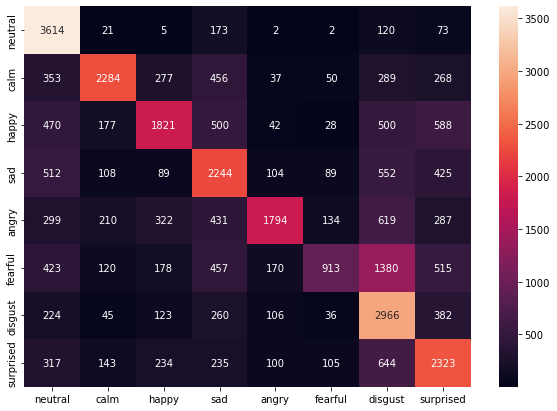

In [11]:
y_true, y_pred = U.recon_and_classiffication_accuracy(model, num_samples=2048)
cr = classification_report(y_true, y_pred, target_names=labels)
cm = confusion_matrix(y_true, y_pred)
cm = pd.DataFrame(cm, index = [i for i in labels],columns = [i for i in labels])

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt="d")
print(cr)